# **Data Collection and Anonymization**

In [1]:
# Install necessary libraries
!pip install tweepy
!pip install tensorflow
!pip install tensorflow_federated
!pip install tensorflow_privacy
!pip install phe
!pip install spacy
!pip install diffprivlib

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.

# **Data Collection and Anonymization**

In [2]:
import re
import spacy
import tweepy
import numpy as np
import pandas as pd
import phe as paillier
import tensorflow as tf
from scipy import sparse
import matplotlib.pyplot as plt
import tensorflow_privacy as tfp
import tensorflow_federated as tff
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from diffprivlib.models import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

##### Loading the Dataset.

In [3]:
# Load the dataset
data_url = "/content/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(data_url, encoding='latin-1', names=["target", "id", "date", "flag", "user", "text"])
df = df[['text', 'target']]
df['target'] = df['target'].map({0: 0, 4: 1})

##### The function is designed to sanitize a given input text by removing potentially sensitive information, particularly user mentions and URLs, which are common in social media posts and other user-generated content. The function first checks if the input is a string; if not, it returns an empty string, ensuring it only processes valid text inputs. Using the `re` module for regular expressions, the function then identifies and replaces all user mentions (e.g., `@username`), thereby anonymizing the identities of mentioned users. Next, it removes any URLs from the text, which could contain sensitive information or lead to external sites that might compromise privacy. By performing these operations, the function aims to create a version of the text that retains its original content while protecting user privacy and preventing the sharing of potentially sensitive or identifying information. The final output is a sanitized, anonymized text that can be safely used in contexts where privacy is a concern.

In [4]:
# anonymize_text function
# De-identify text
def deidentify_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'www\S+', '', text)  # Remove URLs
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    return text.strip()

df['text'] = df['text'].apply(deidentify_text)
print(df.head())

                                                text  target
0  A thats a bummer  You shoulda got David Carr o...       0
1  is upset that he cant update his Facebook by t...       0
2  I dived many times for the ball Managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no its not behaving at all im mad why am i her...       0


# **Differential Privacy for Text Data**

##### Text data is converted into a numerical format suitable for model training. The `CountVectorizer` transforms the text data into a matrix of token counts, which represents the frequency of each word in the dataset. The parameter `stop_words='english'` instructs the vectorizer to ignore common English stop words (e.g., 'the', 'is', 'at', 'which', 'on'), which typically do not contribute meaningful information for the classification task. The `fit_transform()` method is then applied to the 'text' column of the dataframe `df`, which performs two operations: it learns the vocabulary dictionary of all tokens in the raw text data (fitting) and then transforms the text data into a sparse matrix `X`, where each row corresponds to a document (tweet), and each column corresponds to a token. The values in this matrix indicate the count of each token in the document. Additionally, the target values, which indicate the sentiment of the text, are extracted into the array `y`.

In [5]:
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['target'].values

##### Adds differential privacy noise to the text data by controlling two key parameters: epsilon and sensitivity. **Epsilon**, set to 1.0, represents the privacy budget, balancing the trade-off between privacy and model accuracy. A lower epsilon value would provide more privacy but reduce accuracy, while a higher value would do the opposite. **Sensitivity**, also set to 1.0, indicates the maximum impact that a single data point can have on the output, such as the word count in this case. Together, these parameters govern the introduction of Laplace noise to the data, ensuring individual privacy while still allowing the data to be used effectively in machine learning models.

In [6]:
# Add differential privacy noise
epsilon = 1.0  # Privacy budget
sensitivity = 1.0  # Sensitivity of the word counts

##### Identifying all the non-zero entries in the sparse matrix `X`, which contains the vectorized representations of text data, using `X.nonzero()`. This function returns the row and column indices (`rows` and `cols`) of the non-zero elements, thus focusing on the meaningful data points for noise addition. Laplace noise, which is commonly used in differential privacy, is then generated for each non-zero entry. The noise is centered around zero, with a spread determined by the `sensitivity` divided by the `epsilon` (privacy budget), ensuring that the noise level is sufficient to mask the contributions of any single data point. This selective addition of noise protects individual privacy while preserving the overall utility of the data for subsequent analysis and machine learning tasks.

In [7]:
# Create noise only for the non-zero values in the original matrix
rows, cols = X.nonzero()
noise = np.random.laplace(0, sensitivity / epsilon, size=len(rows))

##### Transforms the generated noise into a sparse matrix format, which matches the structure of the original data matrix `X`. The `sparse.csr_matrix` function is used to create a Compressed Sparse Row (CSR) matrix, where the `noise` array provides the data, and the `rows` and `cols` arrays specify the corresponding positions in the matrix where the noise values should be placed. This ensures that noise is only added to the non-zero elements of the original matrix. Once the noise matrix is created, it is added to the original data matrix `X`, resulting in a new matrix `X_noisy` that contains both the original data and the added noise. The use of sparse matrix operations is crucial here, as it maintains computational efficiency and minimizes memory usage, which is especially important when working with large datasets. Finally, the shape of the noisy data matrix is printed to confirm that it matches the original data structure, indicating that the noise addition process has been successfully completed.

In [8]:
# Create a sparse matrix from the noise
noise_matrix = sparse.csr_matrix((noise, (rows, cols)), shape=X.shape)

# Add the noise to the original sparse matrix
X_noisy = X + noise_matrix

print("Shape of noisy data:", X_noisy.shape)

Shape of noisy data: (1600000, 447887)


# **Adversarial Model & Evaluation**

##### Splitting the datasset into training and test set.

In [9]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

##### The classifier is configured to use the `'log_loss'` function, suitable for binary classification problems, allowing the model to predict probabilities by optimizing the logistic regression loss function. The `alpha` parameter is set to `1.0 / epsilon`, where `epsilon` represents the differential privacy budget, effectively controlling the regularization strength and thus how much the model can overfit to the training data. Setting `max_iter=1` specifies that only one epoch over the training dataset will be performed, and `warm_start=True` enables the model to continue training from the solution of the previous call to `partial_fit`, rather than starting from scratch each time. This approach is particularly useful when training the model incrementally on chunks of data. Finally, `n_iter_no_change=1` sets the number of iterations with no improvement in the model's performance after which the training will be stopped.

In [10]:
# Initialize the model
clf = SGDClassifier(loss='log_loss', alpha=1.0 / epsilon, max_iter=1, warm_start=True, n_iter_no_change=1)

##### The function takes three arguments: `X`, which is the feature matrix; `y`, which is the target vector; and `chunk_size`, which defines the number of samples to be included in each chunk, with a default size of 10,000 samples. It calculates the total number of samples in the dataset using `X.shape[0]`. Then, it iterates over the dataset by creating a range from 0 to the total number of samples, advancing by `chunk_size` steps each time. For each iteration, the function calculates the `end` index as the minimum of the current starting index plus the `chunk_size` and the total number of samples to ensure it doesn't exceed the dataset boundaries. The function then uses Python's `yield` keyword to return a generator that yields slices of the feature matrix `X` and the target vector `y` corresponding to the current chunk.

In [11]:
# Function to process data in chunks
def process_in_chunks(X, y, chunk_size=10000):
    num_samples = X.shape[0]
    for start in range(0, num_samples, chunk_size):
        end = min(start + chunk_size, num_samples)
        yield X[start:end], y[start:end]

##### The `for` loop iterates over the training data in chunks, where each chunk consists of a subset of the feature matrix `X_train` and the corresponding target vector `y_train`. For each chunk, the `partial_fit` method of the `SGDClassifier` is called, which updates the model's parameters based on the current chunk of data. The `partial_fit` method is particularly useful for handling large datasets or streaming data, as it allows the model to be trained in smaller batches rather than requiring all the data to be loaded into memory at once. The `classes=np.unique(y)` parameter specifies the possible classes for the target variable, ensuring that the model is aware of all possible class labels throughout the incremental training process.

In [12]:
# Train the model incrementally
for X_train_chunk, y_train_chunk in process_in_chunks(X_train, y_train):
    clf.partial_fit(X_train_chunk, y_train_chunk, classes=np.unique(y))

##### It takes the test feature matrix `X_test`, the test target vector `y_test`, the trained classifier `clf`, and an optional `chunk_size` parameter that defines the size of each data chunk. The function first calculates the total number of samples in the test set and initializes an empty list to store predictions. It then iterates over the test data in chunks of the specified size. For each chunk, the function extracts a subset of the test data, makes predictions using the `predict` method of the classifier, and appends these predictions to the list. Finally, it converts the list of predictions into a NumPy array and returns it.

In [13]:
# Function to evaluate the model in chunks
def evaluate_in_chunks(X_test, y_test, clf, chunk_size=10000):
    num_samples = X_test.shape[0]
    predictions = []
    for start in range(0, num_samples, chunk_size):
        end = min(start + chunk_size, num_samples)
        X_test_chunk = X_test[start:end]
        y_test_chunk = y_test[start:end]
        y_pred_chunk = clf.predict(X_test_chunk)
        predictions.extend(y_pred_chunk)
    return np.array(predictions)

##### The line `y_pred = evaluate_in_chunks(X_test, y_test, clf)` passes the test feature matrix `X_test`, the test target vector `y_test`, and the trained classifier `clf` to the function. This function evaluates the model in chunks, processing manageable portions of the test data, and returns the predictions for the entire test set. The result, `y_pred`, is an array containing the predicted labels for each sample in the test dataset.

In [14]:
# Test set evaluation
y_pred = evaluate_in_chunks(X_test, y_test, clf)

##### The `accuracy_score` function from the `sklearn.metrics` module computes the proportion of correct predictions out of the total number of predictions. The result, stored in the variable `accuracy`, is then printed to the console with a formatted message showing the accuracy to four decimal places. This value indicates how well the model performed on the test set, with higher values representing better performance.

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5645


##### The line `print(classification_report(y_test, y_pred))` generates and prints a detailed classification report of the model's performance on the test data. This report includes key metrics such as precision, recall, F1-score, and support for each class in the dataset.

- **Precision** measures the proportion of positive identifications that were actually correct.
- **Recall** indicates the proportion of actual positives that were correctly identified.
- **F1-score** is the harmonic mean of precision and recall, providing a single metric that balances both aspects.
- **Support** refers to the number of actual occurrences of the class in the test data.

These metrics help evaluate the model's ability to correctly classify each class, especially in cases where the classes are imbalanced.

In [16]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.18      0.29    200450
           1       0.54      0.95      0.69    199550

    accuracy                           0.56    400000
   macro avg       0.66      0.57      0.49    400000
weighted avg       0.66      0.56      0.49    400000



##### The code snippet `fpr, tpr, thresholds = roc_curve(y_test, y_pred)` computes the Receiver Operating Characteristic (ROC) curve, while `roc_auc = auc(fpr, tpr)` calculates the Area Under the Curve (AUC) for this ROC curve.

- **ROC Curve**: This curve plots the False Positive Rate (FPR) against the True Positive Rate (TPR) at various threshold settings. It visualizes the trade-off between sensitivity (true positive rate) and the rate of false positives as the decision threshold of the classifier is varied.

- **FPR (False Positive Rate)**: This is the rate of incorrectly classifying negative samples as positive.

- **TPR (True Positive Rate)**: This is the rate of correctly identifying positive samples.

- **Thresholds**: These are the different values used to compute FPR and TPR.

- **AUC (Area Under the Curve)**: This value quantifies the overall performance of the classifier. An AUC of 1 indicates a perfect model, while an AUC of 0.5 suggests a model with no discrimination capability (random guessing).

This process helps assess the model’s performance across different thresholds, providing a comprehensive view of its capability to distinguish between positive and negative classes.

In [17]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

##### The code snippet creates and displays a Receiver Operating Characteristic (ROC) curve using Matplotlib. It first initializes a new figure and plots the ROC curve by connecting the False Positive Rate (FPR) and True Positive Rate (TPR) with a dark orange line, which represents the model’s performance. A diagonal dashed line is added to indicate the performance of a random classifier, serving as a baseline for comparison. The x-axis and y-axis are set to range from 0 to 1, with the y-axis extending slightly above 1 for clarity. Labels are added to both axes and a title is set for the plot. The legend is positioned in the lower right corner, and finally, the plot is displayed, allowing for visual assessment of the model's classification performance and comparison with other models.

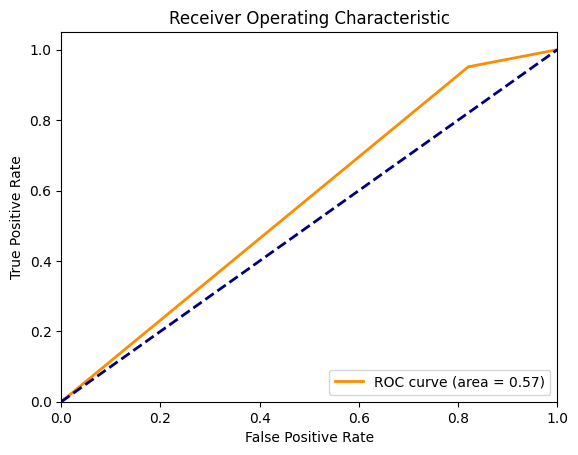

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Homomorphic Encryption**

##### Initializes a `CountVectorizer` to convert text data into numeric vectors, while excluding common stop words. The vectorizer is then fit on the entire text column to learn the vocabulary. The function iterates through the text data in chunks, where each chunk is transformed into vectors using the pre-fitted vectorizer. These vectors are collected and combined into a single sparse matrix using `sparse.vstack`, ensuring efficient memory usage. The result, stored in `df_vectorized`, is a sparse matrix representing the text data in numeric form, ready for further processing or analysis.

In [27]:
# Vectorize text data in chunks
def text_to_vector_in_chunks(df, chunk_size=10000):
    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit(df['text'])

    num_samples = len(df)
    vectors = []
    for start in range(0, num_samples, chunk_size):
        end = min(start + chunk_size, num_samples)
        chunk = df['text'][start:end]
        chunk_vectorized = vectorizer.transform(chunk)
        vectors.append(chunk_vectorized)

    return sparse.vstack(vectors)

df_vectorized = text_to_vector_in_chunks(df)

##### The `encrypt_data` function takes a list of data and a public key, encrypting each element using the public key's `encrypt` method, and returns the list of encrypted data. Conversely, the `decrypt_data` function takes the list of encrypted data and a private key, decrypting each element using the private key's `decrypt` method, and returns the list of decrypted data. These functions facilitate secure handling of sensitive data by ensuring it is encrypted before storage or transmission and can be decrypted back to its original form when needed.

In [28]:
# Function to encrypt and decrypt data
def encrypt_data(data, public_key):
    encrypted_data = [public_key.encrypt(x) for x in data]
    return encrypted_data

def decrypt_data(encrypted_data, private_key):
    decrypted_data = [private_key.decrypt(x) for x in encrypted_data]
    return decrypted_data

##### The line `public_key, private_key = paillier.generate_paillier_keypair()` generates a key pair for the Paillier cryptosystem. Paillier is a type of probabilistic encryption algorithm known for its additive homomorphic properties, which allow computations to be performed on encrypted data without needing to decrypt it first. The `generate_paillier_keypair()` function creates a pair of keys: a public key and a private key. The public key is used for encrypting data, ensuring that the data is securely encoded and can only be decrypted by someone who has the corresponding private key.

In [29]:
# Generate Paillier key pair
public_key, private_key = paillier.generate_paillier_keypair()

##### First removes the 'text' column from `df` to retain only the non-text features. Then, it converts the sparse matrix of vectorized text data (`df_vectorized`) into a dense DataFrame using `toarray()`, which is necessary for standard DataFrame operations. Finally, `pd.concat` merges these two DataFrames along the columns (`axis=1`), combining the original features with the newly generated numerical features from the text data. This results in `df_merged`, a DataFrame that includes all the original data plus the vectorized representation of the text, facilitating further analysis or machine learning tasks.

In [ ]:
# Merge the vectorized data with the original DataFrame, excluding original text
df_merged = pd.concat([df.drop('text', axis=1), pd.DataFrame(df_vectorized.toarray())], axis=1)

##### `encrypted_data = encrypt_data(df_merged.values.flatten(), public_key)` encrypts the entire merged DataFrame `df_merged` by first flattening it into a one-dimensional array with `df_merged.values.flatten()`. This transformation ensures that all the values in the DataFrame, regardless of their original structure, are treated as a single sequence of data points. Each value in this flattened array is then encrypted using the provided `public_key` through the `encrypt_data` function. This process generates an encrypted version of the data, which is printed to verify the result. Flattening the DataFrame before encryption simplifies the handling of the data, but it loses the original structure, which might be necessary for later decryption and reconstruction.

In [ ]:
# Encrypt the entire merged DataFrame
encrypted_data = encrypt_data(df_merged.values.flatten(), public_key)
print('Encrypted Data:', encrypted_data)

##### `decrypted_data = decrypt_data(encrypted_data, private_key)` decrypts the previously encrypted data using the `private_key` through the `decrypt_data` function. This function transforms each encrypted value back into its original form. After decryption, the resulting array is converted into a NumPy array and reshaped to match the original shape of `df_merged` using `reshape(df_merged.shape)`. This step is crucial to restore the original structure of the DataFrame before encryption. The final output, `decrypted_data`, is printed to verify the decryption process and ensure that the data has been accurately restored to its pre-encrypted format.

In [ ]:
# Decrypt the data
decrypted_data = decrypt_data(encrypted_data, private_key)
decrypted_data = np.array(decrypted_data).reshape(df_merged.shape)
print('Decrypted Data:', decrypted_data)